In [1]:
import pandas as pd
df_wine = pd.read_csv(
    'https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data',
    header = None)

In [2]:
df_wine.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [3]:
X = df_wine.iloc[:, 1:].values
y = df_wine.iloc[:, 0].values

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
                                                    X, 
                                                    y,
                                                    test_size=0.3,
                                                    stratify=y,
                                                    random_state=0
                                                )

## Step 1: Standardization

In [25]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_lda = sc.transform(X_test)

In [26]:
import numpy as np
np.set_printoptions(precision=4)
mean_vecs = []

## Step 2. d-Dimensional Mean vector

In [8]:
for label in range(1,4):
    mean_vecs.append(np.mean(
                    X_train_std[y_train==label], axis=0))
    print('MV %s: %s\n'%(label, mean_vecs[label-1]))

MV 1: [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075]

MV 2: [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253]

MV 3: [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013]



## Step 3. Construct between-class matrix and within-class matrix

- within-class scatter matrix $Sw$

In [9]:
d = 13 # the dimension of features
S_W = np.zeros((d, d))
# iterate the class --> i = 3
for label, mv in zip(range(1,4), mean_vecs):
    class_scatter = np.zeros((d, d))
    # iterate the feature --> d = 13
    for row in X_train_std[y_train == label]:
        # change the keepdim=True
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)
        class_scatter += (row - mv).dot((row - mv).T)
    S_W += class_scatter

- Assumption --> Uniform distribution

In [10]:
print('Within-class scatter matrix: %sx%s' %(
        S_W.shape[0], S_W.shape[1]))

Within-class scatter matrix: 13x13


- Look: it is not

In [11]:
print('Class label distribution: %s' % np.bincount(y_train)[1:])
# The result of binning the input array

Class label distribution: [41 50 33]


- scale the individual scatter matrices

- The covariance matrix is a normalized version of the scatter matrix

In [12]:
# d = 13 # the dimension of features
# S_W = np.zeros((d, d))
# # iterate the class --> i = 3
# for label, mv in zip(range(1,4), mean_vecs):
#     class_scatter = np.cov(X_train_std[y_train==label].T)
#     S_W += class_scatter
    
d = 13 # number of features 
S_W = np.zeros((d, d)) 
for label,mv in zip(range(1, 4), mean_vecs): 
    class_scatter = np.cov(X_train_std[y_train==label].T) 
    S_W += class_scatter 

In [13]:
# mean_overall = np.mean(X_train_std, axis=0)
# d = 13 # number of features
# S_B = np.zeros((d, d))
# for i, mean_vec in enumerate(mean_vecs):
#     n = X_train[y_train == i + 1, :].shape[0]
#     mean_vec = mean_vec.reshape(d, 1)
#     mean_overall = mean_overall.reshape(d,1)
# #     # broadcasting
#     S_B += n * (mean_vec - mean_overall).dot(
#                (mean_vec - mean_overall).T)


mean_overall = np.mean(X_train_std, axis=0) 
d = 13  # number of features 
S_B = np.zeros((d, d)) 
for i, mean_vec in enumerate(mean_vecs): 
    n = X_train[y_train == i + 1, :].shape[0] 
    mean_vec = mean_vec.reshape(d, 1)  # make column vector 
    mean_overall = mean_overall.reshape(d, 1) 
    S_B += n * (mean_vec - mean_overall).dot( (mean_vec - mean_overall).T)

In [14]:
 print('Between-class scatter matrix: %sx%s' % (S_B.shape[0], S_B.shape[1]))

Between-class scatter matrix: 13x13


## Step 4. Compute eigen value and eigen vector

In [15]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

In [16]:
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
eigen_pairs.sort(key=lambda x: x[0], reverse=True)

In [17]:
print('Eigenvalue in descending order: \n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalue in descending order: 

349.6178089059939
172.76152218979388
3.7853134512521556e-14
2.117398448224407e-14
1.5164618894178885e-14
1.5164618894178885e-14
1.3579567140455979e-14
1.3579567140455979e-14
7.587760371654683e-15
5.906039984472233e-15
5.906039984472233e-15
2.256441978569674e-15
0.0


## Step 5. Select Linear discriminants for the new feature subspace

In [18]:
import numpy as np
import matplotlib.pyplot as plt
tot = np.sum(eigen_vals)
# sort the value in the decrease order
var_exp = [(i / tot) for i in 
            sorted(eigen_vals, reverse=True)]
# return the cumsum to check the cummulative variance
cum_var_exp = np.cumsum(var_exp)

plt.bar(range(1,14), var_exp, alpha=0.5, align='center',
        label='individual explained variance')
        
plt.step(range(1, 14), cum_var_exp, where='mid',
        label='cumulative explained variance')
plt.ylabel('Exlained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

C:\Users\ruire\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\transforms.py:796: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)
C:\Users\ruire\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<Figure size 640x480 with 1 Axes>

## Step 6. Choose k eigen vector

In [19]:
# stack the two most discriminative eigenvector columns
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
               eigen_pairs[1][1][:, np.newaxis].real))

In [20]:
print('Matrix w: \n', w)

Matrix w: 
 [[-0.1481 -0.4092]
 [ 0.0908 -0.1577]
 [-0.0168 -0.3537]
 [ 0.1484  0.3223]
 [-0.0163 -0.0817]
 [ 0.1913  0.0842]
 [-0.7338  0.2823]
 [-0.075  -0.0102]
 [ 0.0018  0.0907]
 [ 0.294  -0.2152]
 [-0.0328  0.2747]
 [-0.3547 -0.0124]
 [-0.3915 -0.5958]]


## Step 7. Project the sample onto new subspace


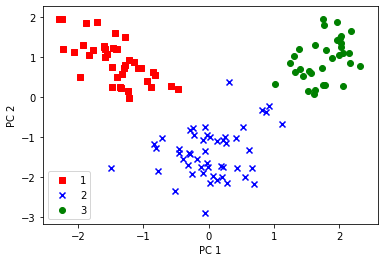

In [29]:
X_train_lda = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for num, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train==num, 0],
                X_train_lda[y_train==num, 1] * (-1), # flip the data
                c=c, label=num, marker=m)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.show()

## Machine learning


In [40]:
from matplotlib.colors import ListedColormap
def plot_decision_region(X, y, classifier, resolution=0.02):
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:,0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:,1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    
    z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    z = z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y==cl, 0],
                    y=X[y==cl, 1],
                    alpha=0.6,
                    color=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx],
                    label=cl)

C:\Users\ruire\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ruire\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


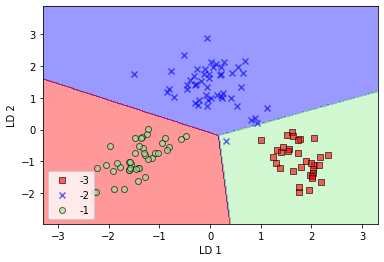

In [41]:
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr = lr.fit(X_train_lda, y_train) 
plot_decision_region(X_train_lda, y_train*(-1), classifier=lr)
plt.xlabel('LD 1') 
plt.ylabel('LD 2') 
plt.legend(loc='lower left') 
plt.show()

# Scikit - learn

C:\Users\ruire\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ruire\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


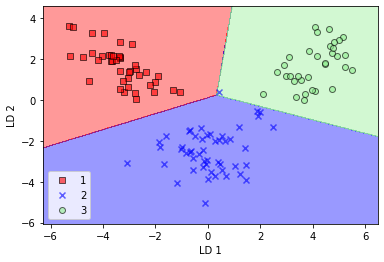

In [43]:
from sklearn.discriminant_analysis import  LinearDiscriminantAnalysis as LDA 
lda = LDA(n_components=2) 
X_train_lda = lda.fit_transform(X_train_std, y_train)
lr = LogisticRegression() 
lr = lr.fit(X_train_lda, y_train) 
plot_decision_region(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD 1') 
plt.ylabel('LD 2') 
plt.legend(loc='lower left') 
plt.show()

In [ ]:
X_test_lda